In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize, BoundaryNorm

from FiberNetModels_2D import MultiAnisoEikonalPINN_2D, SyntheticDataGenerator2D, D_printer

Import of Cupy failed. The GPU version of fimpy will be unavailble. Message: No module named 'cupy'


In [ ]:
#@title Inputs
# These data files are 3D meshes with data
maps_number = 3 #@param {type:"slider", min:1, max:5, step:1}
sample_points = 245 #@param {type:"slider", min:1, max:1500, step:1}
print("Selected values -> maps: %s, sample points: %s" 
        %(maps_number,sample_points))

Selected values -> maps: 3, sample points: 245


In [ ]:
# Run program

# Initialize seed
np.random.seed(0)
tf.random.set_seed(0)

# Assign basic variable values
layers = [3] + [10] * 5 + [1]
CVlayers = [3] + [5] * 5 + [3]
grid_points = 35

# call datagenerator and get fields
synthetic_values = SyntheticDataGenerator2D(grid_points=grid_points, sample_points=sample_points, maps_number=maps_number)
points, triangs, X_mesh, Y_mesh = synthetic_values.get_geometry()
act_times_ref, X_e, T_e, Tmax = synthetic_values.get_activation_maps()
fiber_vecs, cv = synthetic_values.get_fiber_vectors()

# Model initialization
model = MultiAnisoEikonalPINN_2D(points, triangs, maps_number, X_e, T_e,
                        layers, CVlayers, Tmax,
                        CVmax=3.,
                        lambda_pde=1.e-2,
                        lambda_tve=1.*10**-5,
                        lambda_tva=1.*10**-9,
                        lambda_df=1.e0)

# Model training
loss_curve = model.train_Adam_minibatch(int(3e3), size=32)
act_times, CV_out, CV_x, D_2D, D_out, evals, evecs, eik_mismatch = model.predict(points)
x_e = model.X_e

predicted_vecs_3D = np.linalg.eigh(D_out)[1] # Eigenvectors of model values at centroids
D1x, D1y, D2x, D2y = D_printer(D_out)

D_mismatch_rad = np.arccos(np.clip(np.abs(np.sum(fiber_vecs[..., :, 2]*predicted_vecs_3D[..., :, 2],1)),0.,1.))
fiber_orientation_error = np.rad2deg(np.mean(D_mismatch_rad))
D_mismatch_degree_dist = np.rad2deg(np.percentile(D_mismatch_rad, [25,50,75]))
data_fidelity_error = np.sqrt(np.mean((act_times-act_times_ref)**2))

model.sess.close()
tf.compat.v1.reset_default_graph()

print("---Final results---")
print("Mean fiber orientation error: " + str(fiber_orientation_error) + "°")
print("25-50-75 percentiles fiber orientation error: " + str(D_mismatch_degree_dist) + " (°)")
print("RMSE for data fidelity: " + str(data_fidelity_error) + " ms")

Real number of sample points taken:  225


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

---Final results---
Mean fiber orientation error: 2.7702253141039272°
25-50-75 percentiles fiber orientation error: [0.08846933 0.41448698 1.51581565] (°)
RMSE for data fidelity: 0.012841496 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


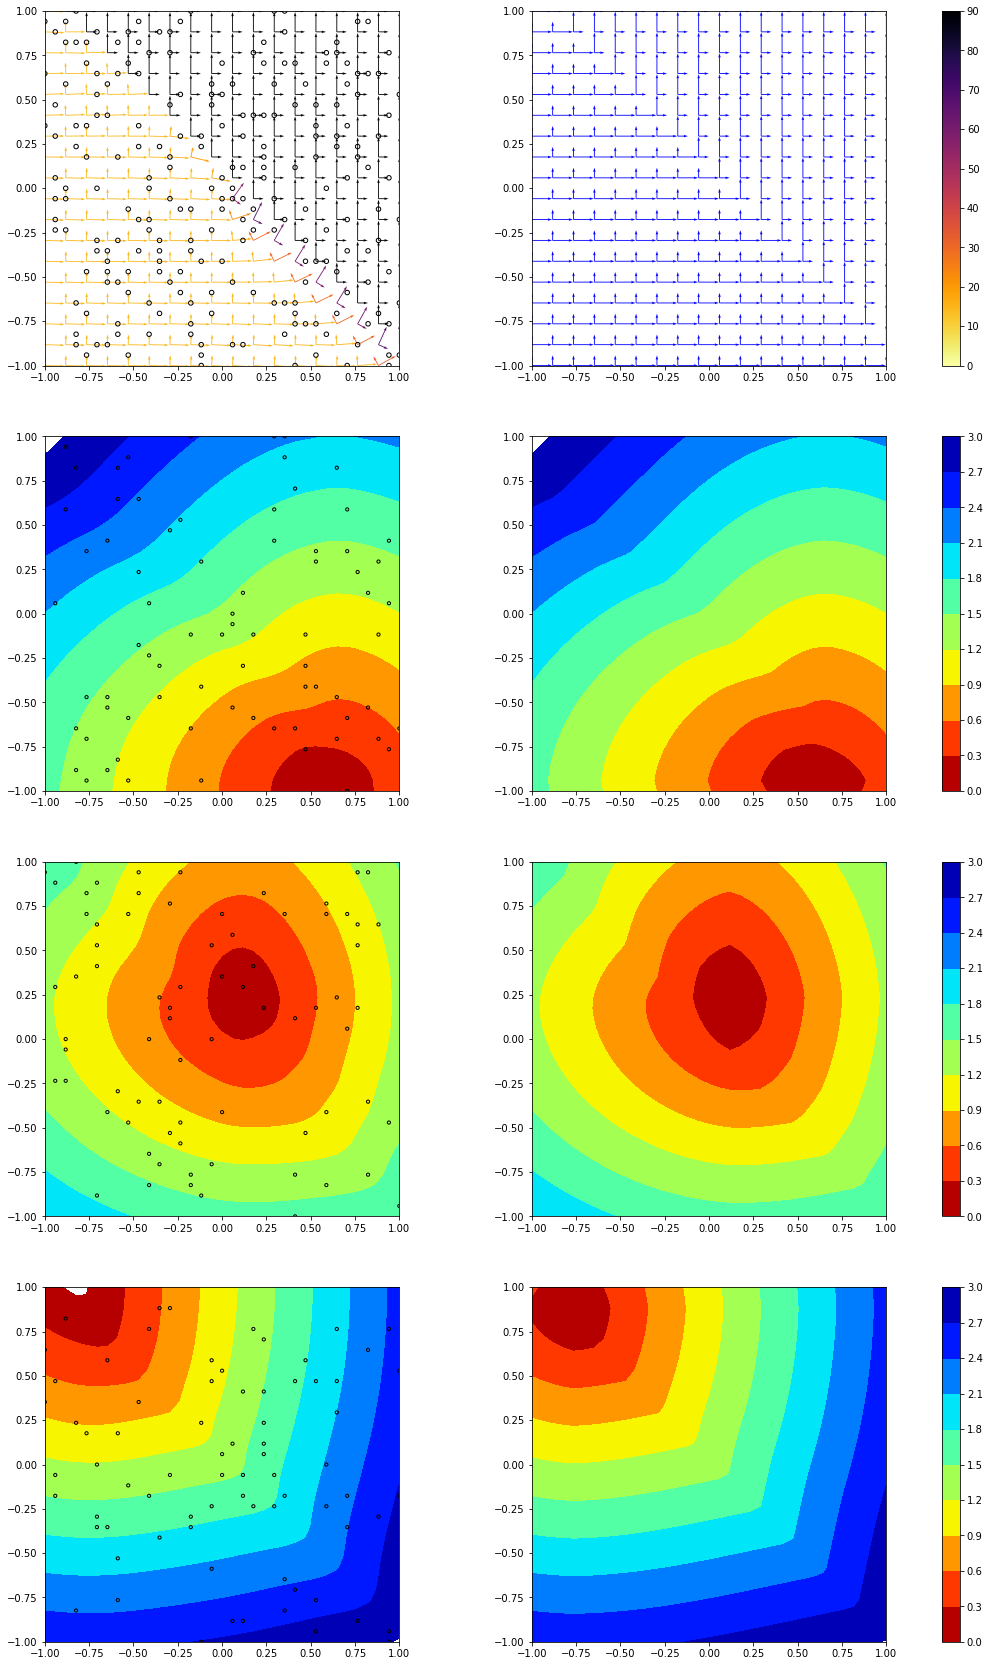

In [ ]:
carray = np.arange(11)*0.3
scale = 2
norm = Normalize(vmin=0.,vmax=90.,clip=False)
norms = BoundaryNorm(boundaries=carray, ncolors=256)
colormap = cm.inferno_r
colormapr = cm.jet_r

fig, axs = plt.subplots(maps_number + 1, 2, figsize=(20,30))
D1x, D1y, D2x, D2y = D_printer(D_out)

for i in np.arange(maps_number):
    ctrf = axs[i+1,1].contourf(X_mesh, Y_mesh, act_times_ref[:,i].reshape(X_mesh.shape),carray,cmap=colormapr)
    axs[i+1,1].set_xlim([-1,1])
    axs[i+1,1].set_ylim([-1,1])
    axs[i+1,1].set_aspect('equal')
    fig.colorbar(ctrf, ax=axs[i+1,:], ticks=carray)

    ctrf = axs[i+1,0].contourf(X_mesh, Y_mesh, act_times[:,i].reshape(X_mesh.shape),carray,cmap=colormapr)
    axs[i+1,0].scatter(x_e[:,0,i], x_e[:,1,i], facecolors = 'none', edgecolor = 'k', s=10)
    axs[i+1,0].set_xlim([-1,1])
    axs[i+1,0].set_ylim([-1,1])
    axs[i+1,0].set_aspect('equal')

for l in range(len(cv[0])):
    if np.mod(l,scale)!=0 or np.mod(l//grid_points,scale)!=0:
        cv[0,l]=cv[1,l]=cv[2,l]=cv[3,l]=0
ratio = np.sqrt(cv[0]**2+cv[1]**2)/np.sqrt(cv[2]**2+cv[3]**2)

axs[0,1].quiver(X_mesh, Y_mesh, abs(cv[0]), cv[1], color='b', scale=grid_points/scale, minlength=0.0001)
axs[0,1].quiver(X_mesh, Y_mesh, abs(cv[2]), cv[3], color='b', scale=grid_points/scale, minlength=0.0001)
axs[0,1].set_xlim([-1,1])
axs[0,1].set_ylim([-1,1])
axs[0,1].set_aspect('equal')

for l in range(len(D1x)):
    if not -np.pi/4 < np.arctan2(D1y[l],D1x[l]) < np.pi*3/4:
        D1x[l]=-D1x[l]
        D1y[l]=-D1y[l]
    if not -np.pi/4 < np.arctan2(D2y[l],D2x[l]) < np.pi*3/4:
        D2x[l]=-D2x[l]
        D2y[l]=-D2y[l]
    if np.mod(l,scale)!=0 or np.mod(l//grid_points,scale)!=0:
        D1x[l]=D2x[l]=D1y[l]=D2y[l]=0

fo = np.squeeze(np.rad2deg(np.arccos(np.clip(np.abs(np.diagonal(np.dot(cv[:2].T,np.hstack([D1x[:,np.newaxis],D1y[:,np.newaxis]]).T))),0.,1.))))
ratio = np.sqrt(D1x**2+D1y**2)/np.sqrt(D2x**2+D2y**2)

qvr = axs[0,0].quiver(X_mesh, Y_mesh, D1x, D1y, color=colormap(norm(fo)), scale=grid_points/scale, minlength=0.0001)
axs[0,0].quiver(X_mesh, Y_mesh, D2x, D2y, color=colormap(norm(fo)), scale=grid_points/scale, minlength=0.0001)
axs[0,0].scatter(x_e[:,0].flatten(), x_e[:,1].flatten(), facecolors = 'none', edgecolor = 'k', s=20)
axs[0,0].set_xlim([-1,1])
axs[0,0].set_ylim([-1,1])
axs[0,0].set_aspect('equal')
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=colormap), ax=axs[0,:])

Text(0, 0.5, 'fiber error [$^o$]')

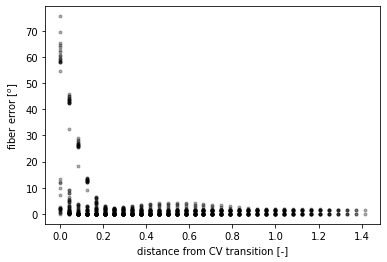

In [ ]:
dist  = (X_mesh.ravel() + Y_mesh.ravel())/np.sqrt(2.)
plt.plot(np.abs(dist), np.rad2deg(D_mismatch_rad),'k.',alpha = 0.3)
plt.xlabel('distance from CV transition [-]')
plt.ylabel('fiber error [$^o$]')